In [21]:
import pymongo
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px  # plotly.express 추가
from IPython.display import display, HTML
import json
from pymongo import MongoClient
from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = '/Users/jiny/Library/Fonts/NanumGothic-Regular.ttf'  # 사용하려는 폰트 경로로 설정
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# MongoDB 연결 설정
client = MongoClient('mongodb://localhost:27017/')
db = client['cycle']

# 인덱스 생성 함수
def create_index(collection_name, indexes):
    collection = db[collection_name]
    collection.create_index(indexes)

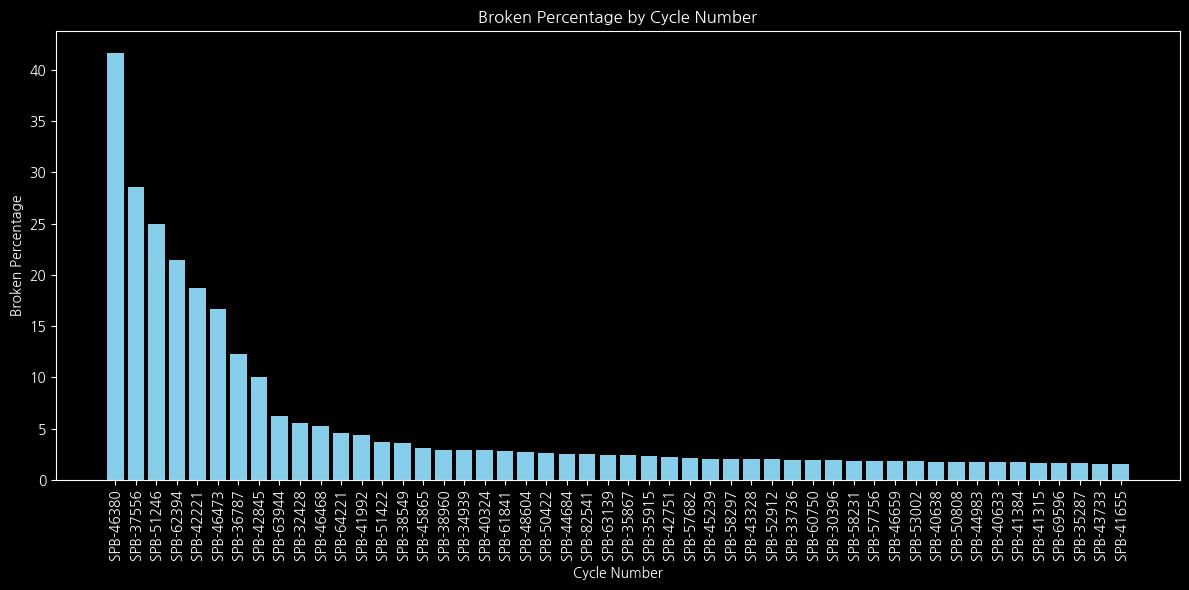

In [22]:
# 1. 자전거 별 고장률 분석

# 복합 인덱스 생성
db['rental_info'].create_index([('cycle_num', 1), ('rental_date', 1)])
db['broken_history'].create_index([('cycle_num', 1), ('broken_date', 1)])

# 1. 자전거 별 고장률 분석
def analyze_broken_rate():
    result = db['rental_info'].aggregate([
        {
            '$group': {
                '_id': '$cycle_num',
                'rental_count': {'$sum': 1}
            }
        },
        {
            '$lookup': {
                'from': 'broken_history',
                'localField': '_id',
                'foreignField': 'cycle_num',
                'as': 'broken_info'
            }
        },
        {
            '$addFields': {
                'broken_count': {'$size': '$broken_info'}
            }
        },
        {
            '$match': {'rental_count': {'$ne': 0}}
        },
        {
            '$addFields': {
                'broken_percentage': {
                    '$multiply': [{'$divide': ['$broken_count', '$rental_count']}, 100]
                }
            }
        },
        {
            '$project': {
                'cycle_num': '$_id',
                'rental_count': 1,
                'broken_count': 1,
                'broken_percentage': {'$round': ['$broken_percentage', 2]}
            }
        },
        {
            '$sort': {'broken_percentage': -1, 'rental_count': -1}
        },
        {
            '$limit': 50
        }
    ])
    
def analyze_broken_rate_from_new_collection():
    result2 = db['broken_rate_analysis'].find()
    data = list(result2)
    df = pd.DataFrame(data)

    plt.figure(figsize=(12, 6))
    plt.bar(df['cycle_num'], df['broken_percentage'], color='skyblue')
    plt.xlabel('Cycle Number')
    plt.ylabel('Broken Percentage')
    plt.title('Broken Percentage by Cycle Number')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

analyze_broken_rate_from_new_collection()

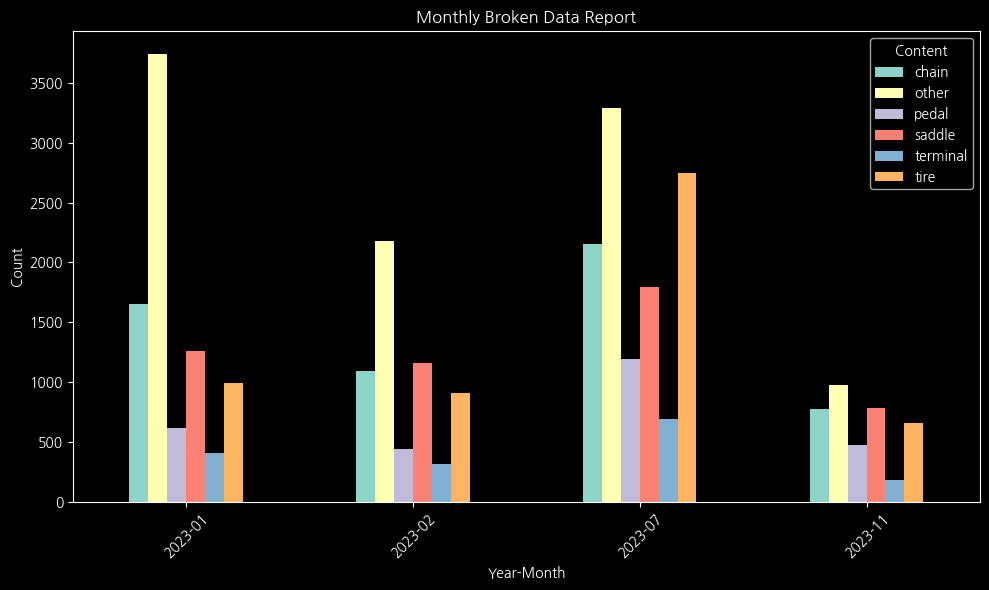

In [23]:
# 2. 월별 고장 내역 분석
def analyze_monthly_broken():
    results = list(db['broken_history'].aggregate([
        {
            '$project': {
                'year': {'$year': '$created_at'},
                'month': {'$month': '$created_at'},
                'content': {'$trim': {'input': '$content'}}
            }
        },
        {
            '$group': {
                '_id': {'year': '$year', 'month': '$month'},
                'total_count': {'$sum': 1},
                'details': {'$push': {'content': '$content'}}
            }
        },
        {
            '$unwind': '$details'
        },
        {
            '$group': {
                '_id': {'year': '$_id.year', 'month': '$_id.month', 'content': '$details.content'},
                'count': {'$sum': 1}
            }
        },
        {
            '$group': {
                '_id': {'year': '$_id.year', 'month': '$_id.month'},
                'total_count': {'$first': '$count'},
                'details': {'$push': {'content': '$_id.content', 'count': '$count'}}
            }
        },
        {
            '$project': {
                '_id': 0,
                'year': '$_id.year',
                'month': '$_id.month',
                'count': '$total_count',
                'detail': {'$sortArray': {'input': '$details', 'sortBy': {'count': -1}}}
            }
        },
        {
            '$sort': {'year': 1, 'month': 1}
        }
    ]))

    if not results:
        print("No data found from MongoDB query.")
    else:
        content_mapping = {
            "기타": "other",
            "단말기": "terminal",
            "안장": "saddle",
            "체인": "chain",
            "타이어": "tire",
            "페달": "pedal"
        }

        data = []
        for result in results:
            year_month = f"{result['year']}-{result['month']:02d}"
            for detail in result['detail']:
                content_english = content_mapping.get(detail['content'], detail['content'])
                data.append([year_month, content_english, detail['count']])

        df = pd.DataFrame(data, columns=['Year-Month', 'Content', 'Count'])
        df['Count'] = df['Count'].astype(int)
        df = df.sort_values(['Year-Month', 'Count'], ascending=[True, False])
        pivot_df = df.pivot(index='Year-Month', columns='Content', values='Count').fillna(0)
        pivot_df.plot(kind='bar', stacked=False, figsize=(10, 6))

        plt.title('Monthly Broken Data Report')
        plt.xlabel('Year-Month')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Content')
        plt.tight_layout()
        plt.show()

analyze_monthly_broken()

In [24]:
# MongoDB 컬렉션에서 데이터 가져오기
collection = db['best_rental_place']
data = list(collection.find({}, {'_id': 0, 'station_id': 1, 'rental_count': 1, 'latitude': 1, 'longitude': 1}))

# 데이터를 JSON 형태의 문자열로 변환
stations_data = json.dumps(data)

# HTML 코드
html_template = """
<!DOCTYPE html>
<html>
  <head>
    <title>Station Rentals</title>
    <script src="https://maps.googleapis.com/maps/api/js?key=yourkey" async defer></script>
    <script>
const stations = {stations_data};
console.log('Stations data:', stations);

function initMap() {{
    var map = new google.maps.Map(document.getElementById('map'), {{
      zoom: 12,
      center: {{ lat: 37.5665, lng: 126.9780 }} // 서울의 중심 좌표
    }});

    // 대여소 데이터를 대여 횟수(rental_count) 기준으로 정렬
    stations.sort((a, b) => b.rental_count - a.rental_count);
    console.log('Sorted stations:', stations);

    // 상위 30개 대여소를 빨간색으로 표시
    const topStations = stations.slice(0, 30);
    console.log('Top 30 stations:', topStations);

    // 각 원의 위치를 조금씩 조정하여 겹치지 않도록 합니다.
    const offset = 0.001; // 오프셋 값 조정

    // 상위 30개 대여소를 제외한 나머지 대여소를 그립니다
    stations.slice(30).forEach(function(station, index) {{
        var adjustedLat = station.latitude + (offset * (index % 2 ? 1 : -1));
        var adjustedLng = station.longitude + (offset * (index % 2 ? -1 : 1));
        console.log('Drawing circle for station:', station);

        var circle = new google.maps.Circle({{
          strokeColor: 'blue',
          strokeOpacity: 0.8,
          strokeWeight: 2,
          fillColor: 'skyblue',
          fillOpacity: 0.35,
          map: map,
          center: {{ lat: adjustedLat, lng: adjustedLng }},
          radius: Math.sqrt(station.rental_count) * 3 // 필요한 경우 반경 조정
        }});
    }});

    // 상위 30개 대여소를 먼저 그립니다
    topStations.forEach(function(station, index) {{
        var adjustedLat = station.latitude + (offset * (index % 2 ? 1 : -1));
        var adjustedLng = station.longitude + (offset * (index % 2 ? -1 : 1));
        console.log('Drawing top circle for station:', station);

        var circle = new google.maps.Circle({{
          strokeColor: 'red',
          strokeOpacity: 0.8,
          strokeWeight: 2,
          fillColor: 'red',
          fillOpacity: 0.35,
          map: map,
          center: {{ lat: adjustedLat, lng: adjustedLng }},
          radius: Math.sqrt(station.rental_count) * 3 // 필요한 경우 반경 조정
        }});
    }});

}}
    </script>
  </head>
  <body>
    <div id="map" style="height: 800px; width: 100%;"></div>
  </body>
</html>
"""

# HTML 코드에 JSON 데이터 삽입
html_code = html_template.format(stations_data=stations_data)

# HTML 표시
display(HTML(html_code))

In [25]:
# 4. 월별 자전거 사용량 분석

def analyze_monthly_usage():
    coll = db.cycle_usage_monthly.find().sort([('_id.month', 1)])
    x = []
    count = []
    avg_minute = []
    for document in coll:
        x.append(int(document['_id']['month']))
        count.append(int(document['count']))
        avg_minute.append(int(document['avg_minute']))

    trace1 = go.Scatter(x=x, y=count, mode='lines+markers', name='count')
    trace2 = go.Scatter(x=x, y=avg_minute, mode='lines', name='avg_minute')

    data = [trace1]
    fig = go.Figure(data=data)
    fig.show()

    data = [trace2]
    fig = go.Figure(data=data)
    fig.show()


analyze_monthly_usage()

In [26]:
# 5. 자전거 사용 history 분석
create_index('rental_place_monthly', [('_id.month', 1)])

def analyze_usage_history():
    month = 7
    coll = db.rental_place_monthly.find({'_id.month': month}).sort([('rentalCount', -1)]).limit(20)
    rental_place = []
    rental_count = []
    for document in coll:
        rental_place.append(document['_id']['rental_place'])
        rental_count.append(int(document['rentalCount']))

    fig = px.pie(names=rental_place, values=rental_count, title='month: {}'.format(month))
    fig.show()

analyze_usage_history()

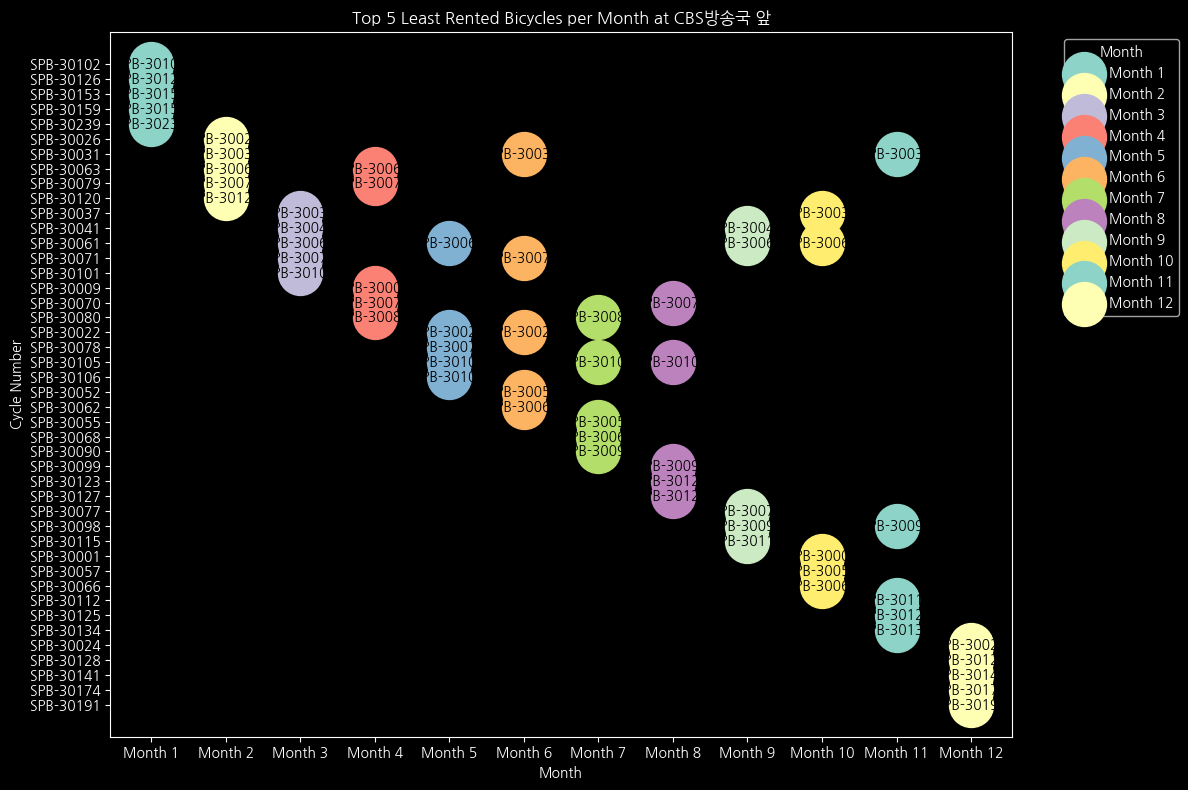

In [27]:
# 7. 자전거 이용량 분석

db = client['cycle']
collection = db['cycle_count_rental_place_monthly']

# 복합 인덱스 생성
collection.create_index([
    ('rental_place', 1),
    ('month', 1),
    ('rental_count', 1)
])

def analyze_least_rented_bikes():
    pipeline = [
        {
            '$match': {
                'rental_place': 'CBS방송국 앞'
            }
        },
        {
            '$sort': {'month': 1, 'rental_count': 1}
        },
        {
            '$group': {
                '_id': '$month',
                'least_rented_bikes': {
                    '$push': {
                        'cycle_num': '$cycle_num',
                        'rental_count': '$rental_count'
                    }
                }
            }
        },
        {
            '$project': {
                'month': '$_id',
                'least_rented_bikes': {'$slice': ['$least_rented_bikes', 5]},
                '_id': 0
            }
        },
        {
            '$unwind': '$least_rented_bikes'
        },
        {
            '$project': {
                'month': 1,
                'cycle_num': '$least_rented_bikes.cycle_num',
                'rental_count': '$least_rented_bikes.rental_count'
            }
        },
        {
            '$sort': {'month': 1, 'rental_count': 1}
        }
    ]

    result = collection.aggregate(pipeline)
    data = list(result)
    df = pd.DataFrame(data)
    df['cycle_num'] = df['cycle_num'].astype(str)
    df['month'] = df['month'].astype(int)

    plt.figure(figsize=(12, 8))
    months = df['month'].unique()

    for i, month in enumerate(months):
        subset = df[df['month'] == month]
        plt.scatter([i] * len(subset), subset['cycle_num'], s=1000, label=f'Month {month}')
        for j, cycle_num in enumerate(subset['cycle_num']):
            plt.text(i, cycle_num, cycle_num, color='black', ha='center', va='center')

    plt.xlabel('Month')
    plt.ylabel('Cycle Number')
    plt.title('Top 5 Least Rented Bicycles per Month at CBS방송국 앞')
    plt.xticks(range(len(months)), [f'Month {month}' for month in months])
    plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

analyze_least_rented_bikes()

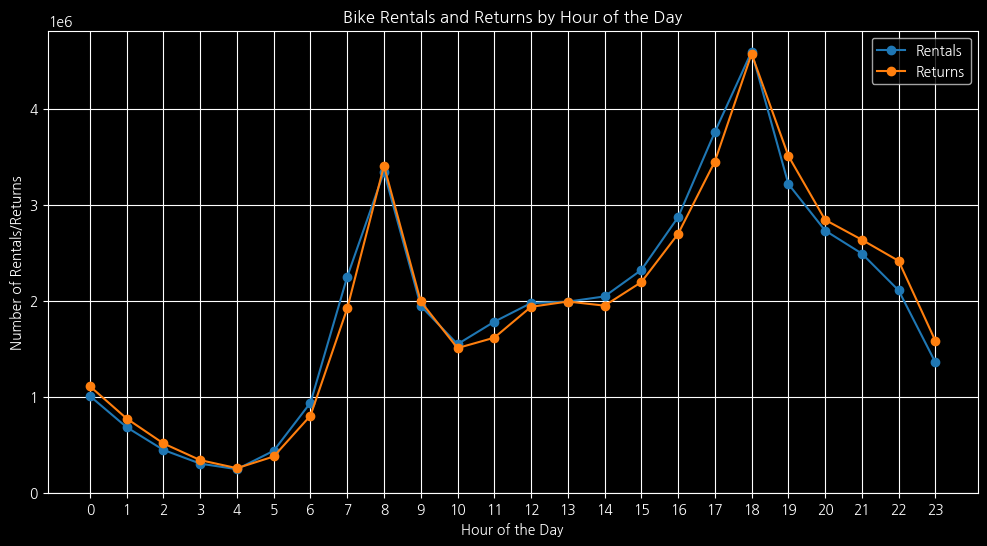

In [28]:
# 저장된 결과 불러오기
result = db.cycle_aggregated.find_one()

# rental_hours와 return_hours 추출
rental_hours = result['rental_hours']
return_hours = result['return_hours']

# Extracting data for visualization
rental_hours_data = {doc['_id']: doc['count'] for doc in rental_hours}
return_hours_data = {doc['_id']: doc['count'] for doc in return_hours}

# Creating lists of hours and counts for plotting
hours = range(24)
rental_counts = [rental_hours_data.get(hour, 0) for hour in hours]
return_counts = [return_hours_data.get(hour, 0) for hour in hours]

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(hours, rental_counts, label='Rentals', marker='o', color='#1f77b4')
plt.plot(hours, return_counts, label='Returns', marker='o', color='#ff7f0e')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rentals/Returns')
plt.title('Bike Rentals and Returns by Hour of the Day')
plt.xticks(hours)
plt.yticks(range(0, max(max(rental_counts), max(return_counts)) + 1, 1000000))  # Y축 레이블을 원하는 값으로 설정
plt.grid(True)
plt.legend()
plt.show()

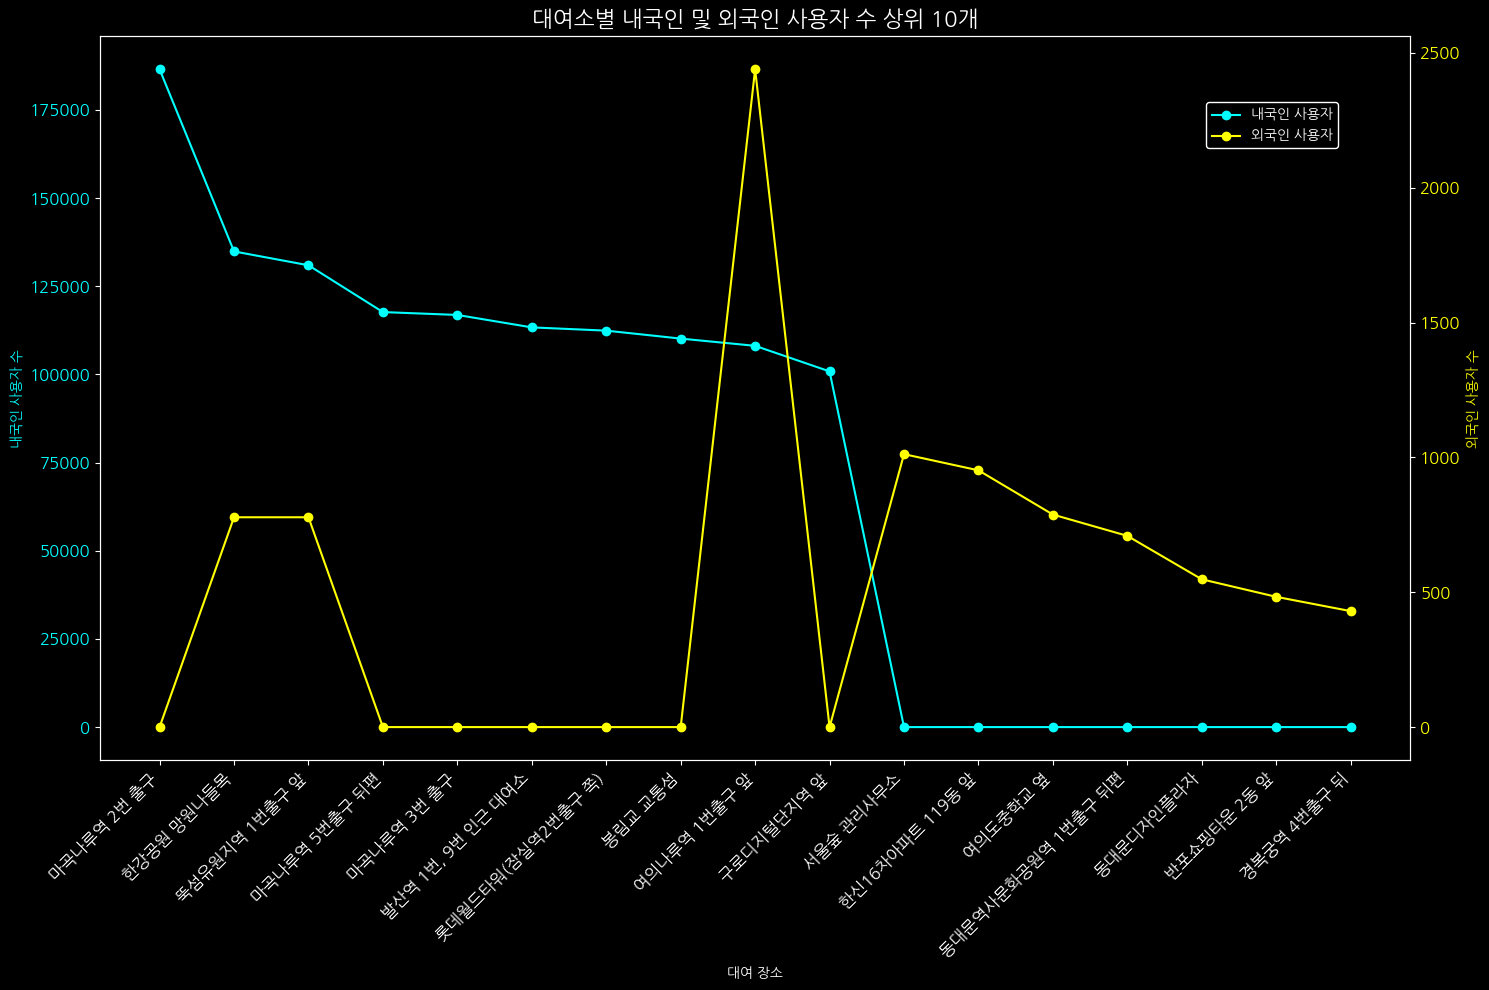

In [29]:
db = client['cycle']
collection = db['rental_info']

# 복합 인덱스 생성
collection.create_index([
    ("user.usr_cls_cd", 1),
    ("rental_place", 1)
])

# 최적화된 쿼리 파이프라인
optimized_pipeline = [
    {
        "$match": {
            "user.usr_cls_cd": {"$in": ["내국인", "외국인"]}
        }
    },
    {
        "$group": {
            "_id": {
                "rental_place": "$rental_place",
                "usr_cls_cd": "$user.usr_cls_cd"
            },
            "totalUsers": {"$sum": 1}
        }
    },
    {
        "$sort": {"totalUsers": -1}
    },
    {
        "$group": {
            "_id": "$_id.usr_cls_cd",
            "places": {
                "$push": {
                    "rental_place": "$_id.rental_place",
                    "totalUsers": "$totalUsers"
                }
            }
        }
    },
    {
        "$project": {
            "_id": 1,
            "top10Places": {
                "$slice": ["$places", 10]
            }
        }
    }
]

result_after_index = list(db.rental_info.aggregate(optimized_pipeline))


# 데이터가 없는 경우를 대비해 예외 처리 추가
native_places = []
native_counts = []
foreigner_places = []
foreigner_counts = []

for doc in result_after_index:
    if doc['_id'] == "내국인":
        native_places = [place['rental_place'] for place in doc['top10Places']]
        native_counts = [place['totalUsers'] for place in doc['top10Places']]
    elif doc['_id'] == "외국인":
        foreigner_places = [place['rental_place'] for place in doc['top10Places']]
        foreigner_counts = [place['totalUsers'] for place in doc['top10Places']]

# Creating a combined DataFrame for easier plotting
df_native = pd.DataFrame({'Place': native_places, 'Native_Count': native_counts})
df_foreigner = pd.DataFrame({'Place': foreigner_places, 'Foreigner_Count': foreigner_counts})

# Merging dataframes on Place
df_combined = pd.merge(df_native, df_foreigner, on='Place', how='outer').fillna(0)

# Plotting the data with a dark background
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plotting native users on the primary y-axis
ax1.plot(df_combined['Place'], df_combined['Native_Count'], color='cyan', marker='o', linestyle='-', label='내국인 사용자')
ax1.set_xlabel('대여 장소', color='white', fontweight='bold')
ax1.set_ylabel('내국인 사용자 수', color='cyan', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='cyan', labelsize=12)
ax1.tick_params(axis='x', labelcolor='white', rotation=45, labelsize=12)

# Creating a secondary y-axis for foreign users
ax2 = ax1.twinx()
ax2.plot(df_combined['Place'], df_combined['Foreigner_Count'], color='yellow', marker='o', linestyle='-', label='외국인 사용자')
ax2.set_ylabel('외국인 사용자 수', color='yellow', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='yellow', labelsize=12)

# Adding title and legend
plt.title('대여소별 내국인 및 외국인 사용자 수 상위 10개', color='white', fontweight='bold', fontsize=16)
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), facecolor='black', edgecolor='white', framealpha=1)

# Setting the background color to black
#fig.patch.set_facecolor('black')
#ax1.set_facecolor('black')
#ax2.set_facecolor('black')

# X축 레이블을 좀 더 왼쪽으로 이동
for label in ax1.get_xticklabels():
    label.set_ha('right')

plt.show()